Binding Kinetics Calculation
=====




In [1]:
import pyemma
import numpy as np
import matplotlib.pyplot as plt
import pyemma.msm as msm
import pyemma.plots as mplt
import pyemma.coordinates as coor
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load Normal MD Data
=====


In [2]:
md_trajs=[]
with open('filename-all-0126', 'r') as myfile:
    flnm=myfile.read().replace('\n', ' ')
flist=flnm.split()

In [3]:
for f in flist:
    ligrmsd_file='./short-set/mal-rmsd/mal-'+f+'.rmsd'
    angle_file='./short-set/angle-cacom/cacom-'+f+'.angle'
    mal_rmsd=np.loadtxt(ligrmsd_file,skiprows=1,usecols=[1])
    mbp_angle=np.loadtxt(angle_file,skiprows=1,usecols=[1])
    sample=np.vstack((mal_rmsd, mbp_angle))
    sample=sample.transpose()
    md_trajs.append(sample)

In [4]:
len(md_trajs)

493

# Markov state modeling

In [5]:
#===========
#Geometric Clustering
#===========
clunum=500
cl=coor.cluster_kmeans(data=md_trajs,k=clunum,max_iter=20)
md_dtrajs = cl.dtrajs

A Jupyter Widget

A Jupyter Widget

09-07-18 14:41:51 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 9 steps.


A Jupyter Widget

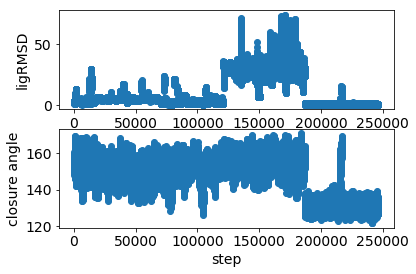

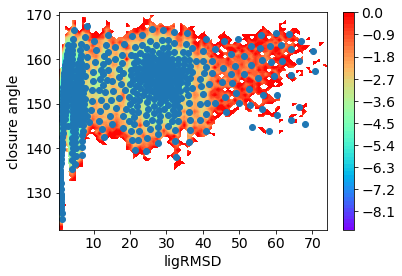

In [54]:
dim1=0
dim2=1
dataset=md_trajs
plt.subplot2grid((2, 1), (0, 0)) 
plt.plot(np.vstack(dataset)[:, dim1],linewidth=0,marker='o')
#plt.xlim(154000,156000)
plt.ylabel('ligRMSD')
plt.subplot2grid((2, 1), (1, 0))
plt.plot(np.vstack(dataset)[:, dim2],linewidth=0,marker='o')
#plt.xlim(154000,156000)
plt.ylabel('closure angle')
plt.xlabel('step')
plt.show()

# histogram data
z_,x_,y_ = np.histogram2d(np.vstack(dataset)[:, dim1], np.vstack(dataset)[:, dim2], bins=80)
# compute free energies
F_ = -np.log(z_)
# contour plot
extent_ = [x_[0], x_[-1], y_[0], y_[-1]]
contourf(F_.T, 80, cmap=plt.cm.rainbow, extent=extent_)
xlabel('ligRMSD'); ylabel('closure angle')
plt.xticks(range(0,80,10))
colorbar()

cc_x = cl.clustercenters[:,dim1]
cc_y = cl.clustercenters[:,dim2]
plt.plot(cc_x,cc_y,linewidth=0,marker='o')

In [7]:
#===========
#MSM Estimation
#===========
lags=[1,2,5,10,20,50,80,100,120,140,160,180,200,220,240]
its = msm.timescales_msm(md_dtrajs, lags=lags,nits=20)

A Jupyter Widget

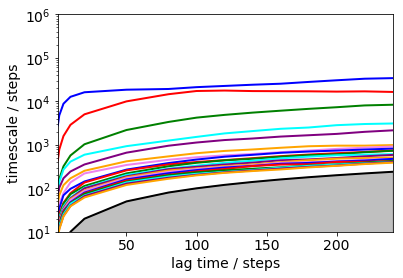

In [8]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, units='steps', linewidth=2)
xlim(1, 240); ylim(10, 10e+5);
#savefig('./its.png', bbox_inches='tight')
plt.show()

In [9]:
lag_fix=200
M=msm.estimate_markov_model(md_dtrajs, lag_fix, dt_traj='0.1 ns')
print('fraction of states used =',M.active_state_fraction)
print('fraction of counts used =',M.active_count_fraction)

fraction of states used = 0.99
fraction of counts used = 0.999630831643002


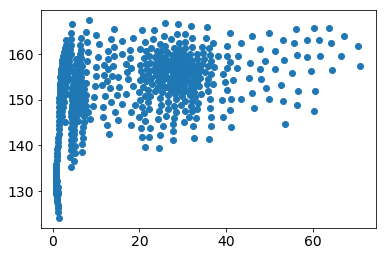

In [10]:
ccx=[]
ccy=[]
for i in M.active_set:
    ccx.append(cl.clustercenters[i,0])
    ccy.append(cl.clustercenters[i,1])

ccx=np.asarray(ccx)
ccy=np.asarray(ccy)

plt.plot(ccx,ccy,linewidth=0,marker='o')

[ 1.          0.99346239  0.98812259  0.97305153  0.93177873  0.8939244
  0.81150355  0.78007962  0.7621766   0.73212359]


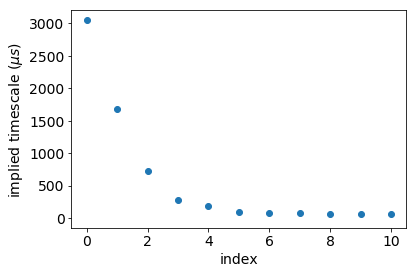

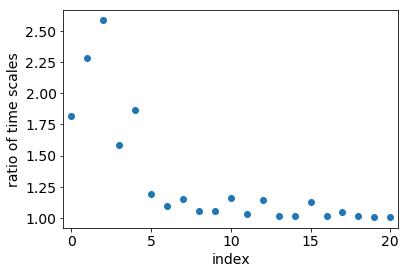

In [11]:
print(M.eigenvalues()[0:10])
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel(r'implied timescale ($\mu s$)'); xlim(-0.5,10.5)
plt.show()

plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('ratio of time scales'); xlim(-0.5,20.5)
#savefig('./spectialgap-tica.png', bbox_inches='tight')
plt.show()

In [12]:
#===========
#Kinetic Clustering
#===========
nmacro=4
M_pcca=M.pcca(nmacro)

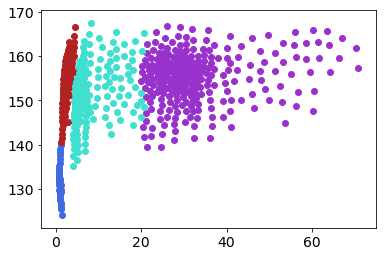

In [13]:
clr=['darkorchid','royalblue','firebrick','turquoise','orange','cyan','indigo','lavender']
for j in range(nmacro):
    for i in M_pcca.metastable_sets[j]:
        plt.scatter(ccx[i],ccy[i],color=clr[j])

In [14]:
#===========
#MFPT on/off rates
#===========
source=0
sink=1
Nsim = 19661.0  # number of water molecules in our simulation
Nstd = 55.55  # number of water molecules in standard volume
ligc = Nstd / Nsim

#prb(bound)/prb(unbound)
Keq=(M_pcca.coarse_grained_stationary_probability[sink]/M_pcca.coarse_grained_stationary_probability[source])/ligc
Kd=1/Keq
G=0.6*np.log(Kd)
print('disociation constant Kd =', Kd*10**6, 'uM')
print('binding free energy G =',G,'kcal/mol')

ton=M.mfpt(M_pcca.metastable_sets[source],M_pcca.metastable_sets[sink])
toff=M.mfpt(M_pcca.metastable_sets[sink],M_pcca.metastable_sets[source])

kon=10**9/(ligc*ton) #unit  M-1s-1
koff=10**9/(toff) #unit s-1
print('ton=',ton,'toff=',toff)
print('association constant kon =', kon*10**(-7), '*10e+7 M-1s-1')
print('dissociation constant koff =', koff, 's-1')
print('koff/kon =', (koff/kon)*10**6, 'uM')

disociation constant Kd = 57.640631754 uM
binding free energy G = -5.85676969593 kcal/mol
ton= 13306.7025546 toff= 325168.668698
association constant kon = 2.65981291674 *10e+7 M-1s-1
dissociation constant koff = 3075.32704183 s-1
koff/kon = 115.621930492 uM


## PCA Analysis


In [15]:
from prody import *
from pylab import *

In [16]:
#===========
#load trajectories and extract data
#===========
with open('trajlist-dcd-0705', 'r') as myfile:
    trjl=myfile.read().replace('\n', ' ')
dcd_list=trjl.split()

trajfile = dcd_list
topfile = 'pro-lig-now.prmtop'
feat = coor.featurizer(topfile)

ca_idx=coor.data.featurization.featurizer.MDFeaturizer.select_Ca(feat)
feat.add_selection(ca_idx)

inp = coor.source(trajfile, feat)
print ('trajectory length = ',inp.trajectory_length(30))
print ('number of trajectories = ',inp.number_of_trajectories())
print ('number of dimension = ',inp.dimension())

A Jupyter Widget

trajectory length =  500
number of trajectories =  493
number of dimension =  1110


In [17]:
trj_all=inp.get_output()
trj_all_stack=vstack(trj_all)

A Jupyter Widget

In [18]:
#===========
#data in each metastable states
#===========
ub_dt=[]
tb_dt=[]
lb_dt=[]
ct_dt=[]
for i in range(len(trj_all)): #trj num
    for j in range(len(trj_all[0])):
        if md_dtrajs[i][j] in M.active_set:
            idx=np.where(M.active_set==md_dtrajs[i][j])
            if idx in M_pcca.metastable_sets[0]:
                ub_dt.append(trj_all[i][j])
            elif idx in M_pcca.metastable_sets[1]:
                tb_dt.append(trj_all[i][j])
            elif idx in M_pcca.metastable_sets[2]:
                lb_dt.append(trj_all[i][j])
            elif idx in M_pcca.metastable_sets[3]:
                ct_dt.append(trj_all[i][j])

ub_dt=np.array(ub_dt)                
tb_dt=np.array(tb_dt)
lb_dt=np.array(lb_dt)
ct_dt=np.array(ct_dt)

In [19]:
structure=parsePDB('pro-lig-now.pdb')

@> 5782 atoms and 1 coordinate set(s) were parsed in 0.07s.


In [20]:
pd_trj=Trajectory(dcd_list[0])

In [21]:
for trj in dcd_list[1:]:
    pd_trj.addFile(trj)

In [22]:
pd_trj.link(structure)
pd_trj.setCoords(structure)
pd_trj.setAtoms(structure.calpha)

In [23]:
eda=EDA('ca_prody')

In [24]:
eda.buildCovariance(pd_trj)

@> Covariance will be calculated using 246500 frames.
@> Covariance matrix calculated in 1058.738522s.


In [25]:
eda.calcModes()

@> 20 modes were calculated in 0.09s.


In [26]:
eda_pc1=eda.getEigvecs()[:,0]

In [27]:
eda_pc2=eda.getEigvecs()[:,1]

In [28]:
all_edapc1=np.dot(trj_all_stack, eda_pc1)

In [29]:
all_edapc2=np.dot(trj_all_stack, eda_pc2)

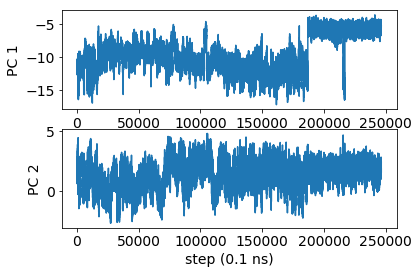

Text(0,0.5,'PC 2')

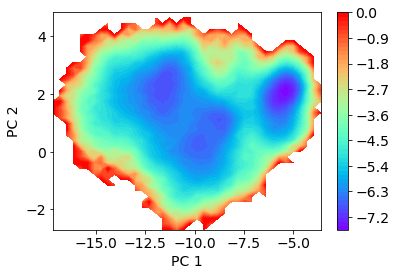

In [30]:
subplot2grid((2,1),(0,0))
plot(all_edapc1)
ylabel('PC 1')
subplot2grid((2,1),(1,0))
plot(all_edapc2)
ylabel('PC 2')
xlabel('step (0.1 ns)')
plt.show()

# histogram data
z_,x_,y_ = np.histogram2d(all_edapc1, all_edapc2, bins=40)
# compute free energies
F_ = -np.log(z_)
# contour plot
extent_ = [x_[0], x_[-1], y_[0], y_[-1]]
contourf(F_.T, 50, cmap=plt.cm.rainbow, extent=extent_)
colorbar()
xlabel('PC 1'); ylabel('PC 2')

In [31]:
ub_dt_edapc1=np.dot(ub_dt,eda_pc1)
ub_dt_edapc2=np.dot(ub_dt, eda_pc2)

In [32]:
tb_dt_edapc1=np.dot(tb_dt,eda_pc1)
tb_dt_edapc2=np.dot(tb_dt, eda_pc2)

In [33]:
lb_dt_edapc1=np.dot(lb_dt,eda_pc1)
lb_dt_edapc2=np.dot(lb_dt,eda_pc2)

In [34]:
ct_dt_edapc1=np.dot(ct_dt,eda_pc1)
ct_dt_edapc2=np.dot(ct_dt,eda_pc2)

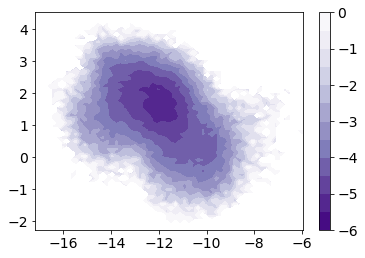

In [35]:
z_ub,x_ub,y_ub = np.histogram2d(ub_dt_edapc1, ub_dt_edapc2, bins=60)
# compute free energies
F_ub = -np.log(z_ub)
# contour plot
extent_ub= [x_ub[0], x_ub[-1], y_ub[0], y_ub[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contourf(F_ub.T, 60, cmap=plt.cm.Purples_r, extent=extent_ub,levels=clr_lev)
colorbar()


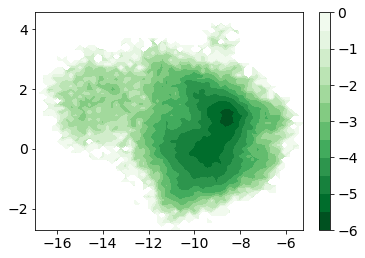

In [36]:
z_ct,x_ct,y_ct = np.histogram2d(ct_dt_edapc1, ct_dt_edapc2, bins=60)
# compute free energies
F_ct = -np.log(z_ct)
# contour plot
extent_ct= [x_ct[0], x_ct[-1], y_ct[0], y_ct[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contourf(F_ct.T, 60, cmap=plt.cm.Greens_r, extent=extent_ct,levels=clr_lev)
colorbar()

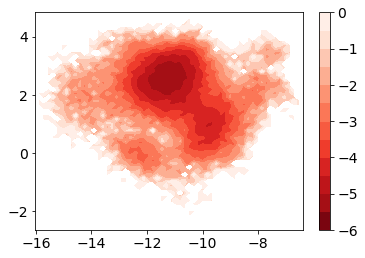

In [37]:
z_lb,x_lb,y_lb = np.histogram2d(lb_dt_edapc1, lb_dt_edapc2, bins=60)
# compute free energies
F_lb = -np.log(z_lb)
# contour plot
extent_lb= [x_lb[0], x_lb[-1], y_lb[0], y_lb[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contourf(F_lb.T, 60, cmap=plt.cm.Reds_r, extent=extent_lb,levels=clr_lev)
colorbar()

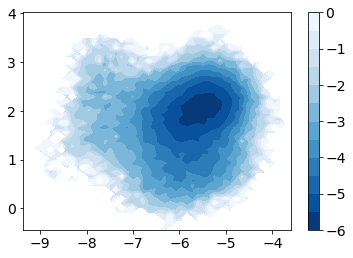

In [38]:
z_tb,x_tb,y_tb = np.histogram2d(tb_dt_edapc1, tb_dt_edapc2, bins=50)
# compute free energies
F_tb = -np.log(z_tb)
# contour plot
extent_tb= [x_tb[0], x_tb[-1], y_tb[0], y_tb[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contourf(F_tb.T, 20, cmap=plt.cm.Blues_r, extent=extent_tb,levels=clr_lev)
colorbar()


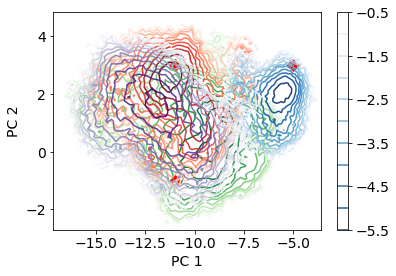

In [39]:
z_ct,x_ct,y_ct = np.histogram2d(ct_dt_edapc1, ct_dt_edapc2, bins=50)
# compute free energies
F_ct = -np.log(z_ct)
# contour plot
extent_ct= [x_ct[0], x_ct[-1], y_ct[0], y_ct[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contour(F_ct.T, 20, cmap=plt.cm.Greens_r, extent=extent_ct,levels=clr_lev)
#colorbar()

z_lb,x_lb,y_lb = np.histogram2d(lb_dt_edapc1, lb_dt_edapc2, bins=50)
# compute free energies
F_lb = -np.log(z_lb)
# contour plot
extent_lb= [x_lb[0], x_lb[-1], y_lb[0], y_lb[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contour(F_lb.T, 20, cmap=plt.cm.Reds_r, extent=extent_lb,alpha=0.9, levels=clr_lev)
#colorbar()

z_tb,x_tb,y_tb = np.histogram2d(tb_dt_edapc1, tb_dt_edapc2, bins=50)
# compute free energies
F_tb = -np.log(z_tb)
# contour plot
extent_tb= [x_tb[0], x_tb[-1], y_tb[0], y_tb[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contour(F_tb.T, 20, cmap=plt.cm.Blues_r, extent=extent_tb,alpha=0.9, levels=clr_lev)
colorbar()

z_ub,x_ub,y_ub = np.histogram2d(ub_dt_edapc1, ub_dt_edapc2, bins=50)
# compute free energies
F_ub = -np.log(z_ub)
# contour plot
extent_ub= [x_ub[0], x_ub[-1], y_ub[0], y_ub[-1]]
clr_lev=np.arange(-6,0.5,0.5)
contour(F_ub.T, 20, cmap=plt.cm.Purples_r, extent=extent_ub,alpha=0.9,levels=clr_lev)
#colorbar()

xlabel('PC 1'); ylabel('PC 2')

plt.scatter([-5.0,-11.0,-11.0],[3.0, 3.0,-1.0], marker='D',c='r',s=70)

In [40]:
all_angle=np.vstack(md_trajs)[:,1]

In [41]:
np.corrcoef(all_angle,all_edapc1)

array([[ 1.        , -0.95126882],
       [-0.95126882,  1.        ]])